In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
!python --version

Python 3.7.12


In [3]:
#!pip install -q git+https://github.com/tensorflow/docs
!python -m venv now_use
!source now_use/bin/activate
!pip install -q git+https://github.com/MJAHMADEE/docs

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Embedding, Dense, Bidirectional,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, CategoricalAccuracy, Recall
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

### Unzip the dataset

In [6]:
import zipfile
df_zip = zipfile.ZipFile('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
dataset = pd.read_csv(df_zip.open('train.csv'))
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


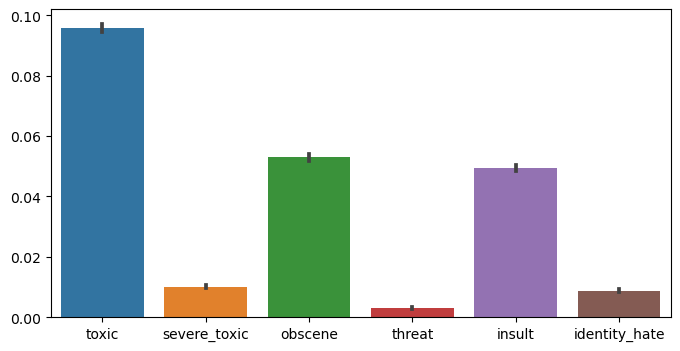

In [7]:
plt.figure(figsize=(8,4))
sns.barplot(dataset)
plt.show()


### Split into X and y

In [8]:
X = dataset['comment_text']
y = dataset[dataset.columns[2:]].values

In [9]:
max_length = 200000

### Text Vectorization

In [10]:
vectorizer = TextVectorization(max_tokens = max_length, output_sequence_length = 1800, output_mode='int')
vectorizer.adapt(X.values)
vectorizer_text = vectorizer(X.values)

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
data_set = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))
data_set = data_set.cache()
data_set = data_set.shuffle(160000)
data_set = data_set.batch(16)
data_set = data_set.prefetch(8) # helps bottlenecks

### Split train data to val and test

In [12]:
train = data_set.take(int(len(data_set)*.7))
val = data_set.skip(int(len(data_set)*.7)).take(int(len(data_set)*.2))
test = data_set.skip(int(len(data_set)*.9)).take(int(len(data_set)*.1))

### Define LSTM model

In [13]:
model = Sequential([
    Embedding(max_length+1, 32),
    Bidirectional(LSTM(32,activation = 'tanh')),
    Dense(128,activation='relu'),
    Dense(256,activation = 'relu'),
    Dense(128,activation = 'relu'),
    Dense(6,activation = 'sigmoid')
])
model.compile(loss = 'BinaryCrossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

You can train it for longer epochs to increase accuracy

In [ ]:
history = model.fit(train, epochs = 1 ,validation_data = val)

1946/6981 [=======>......................] - ETA: 10:10 - loss: 0.1325 - accuracy: 0.9942

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### Model Evaluation

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

### Custom prediction

In [ ]:
input_text = vectorizer('HI')
res = model.predict(np.expand_dims(input_text,0))
(res > 0.5).astype(int)
print(dataset.columns[2:])
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)
res.shape
print(res)

In [ ]:
model.save('/kaggle/working/toxicity.h5')